In [1]:
# Basic Libraries
import pandas as pd
import numpy as np

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Text Libraries
import nltk
import string
import re

# Feature Extraction Libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

# Classifier Model libraries
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree

# Performance Matrix libraries
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')



---

#1. Load Dataset

---



In [2]:
import pandas as pd

data = pd.read_parquet("hf://datasets/dair-ai/emotion/unsplit/train-00000-of-00001.parquet")
data

,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
4,i beleive that i am much more sensitive to oth...,2
...,...,...
416804,that was what i felt when i was finally accept...,1
416805,i take every day as it comes i m just focussin...,4
416806,i just suddenly feel that everything was fake,0
416807,im feeling more eager than ever to claw back w...,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [4]:
data.isna().sum()

text     0
label    0
dtype: int64

In [5]:
data.isnull().sum()

text     0
label    0
dtype: int64

In [6]:
data['label'].unique()

array([0, 1, 2, 3, 4, 5])

In [7]:
#0. sadness, 1. joy, 2. love, 3. anger, 4. fear, 5. surprise
label_mapping = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

data['label'] = data['label'].map(label_mapping)

In [8]:
data['label'].value_counts()


label
joy         141067
sadness     121187
anger        57317
fear         47712
love         34554
surprise     14972
Name: count, dtype: int64



---
#Dataset Emotion Analysis
---





---
#2. Pre-processing text data

---




##2.1. Remove Punctuations

In [9]:
df = data.copy()
emojis = pd.read_csv('./dataset/emojis.txt',sep=',',header=None)
emojis_dict = {i:j for i,j in zip(emojis[0],emojis[1])}
pattern = '|'.join(sorted(re.escape(k) for k in emojis_dict))

def replace_emojis(text):
    text = re.sub(pattern,lambda m: emojis_dict.get(m.group(0)), text, flags=re.IGNORECASE)
    return text

def remove_punct(text):
    text = replace_emojis(text)
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

df['Text_punct'] = df['text'].apply(lambda x: remove_punct(x))
df.head(10)

,text,label,Text_punct
0,i feel awful about it too because it s my job ...,sadness,i feel awful about it too because it s my job ...
1,im alone i feel awful,sadness,im alone i feel awful
2,ive probably mentioned this before but i reall...,joy,ive probably mentioned this before but i reall...
3,i was feeling a little low few days back,sadness,i was feeling a little low few days back
4,i beleive that i am much more sensitive to oth...,love,i beleive that i am much more sensitive to oth...
5,i find myself frustrated with christians becau...,love,i find myself frustrated with christians becau...
6,i am one of those people who feels like going ...,joy,i am one of those people who feels like going ...
7,i feel especially pleased about this as this h...,joy,i feel especially pleased about this as this h...
8,i was struggling with these awful feelings and...,joy,i was struggling with these awful feelings and...
9,i feel so enraged but helpless at the same time,anger,i feel so enraged but helpless at the same time


##2.2 Tokenization

In [10]:
def tokenization(text):
    text = text.lower()
    text = re.split('\W+', text)

    return text

df['Text_tokenized'] = df['Text_punct'].apply(lambda x: tokenization(x.lower()))
df.head(10)

,text,label,Text_punct,Text_tokenized
0,i feel awful about it too because it s my job ...,sadness,i feel awful about it too because it s my job ...,"[i, feel, awful, about, it, too, because, it, ..."
1,im alone i feel awful,sadness,im alone i feel awful,"[im, alone, i, feel, awful]"
2,ive probably mentioned this before but i reall...,joy,ive probably mentioned this before but i reall...,"[ive, probably, mentioned, this, before, but, ..."
3,i was feeling a little low few days back,sadness,i was feeling a little low few days back,"[i, was, feeling, a, little, low, few, days, b..."
4,i beleive that i am much more sensitive to oth...,love,i beleive that i am much more sensitive to oth...,"[i, beleive, that, i, am, much, more, sensitiv..."
5,i find myself frustrated with christians becau...,love,i find myself frustrated with christians becau...,"[i, find, myself, frustrated, with, christians..."
6,i am one of those people who feels like going ...,joy,i am one of those people who feels like going ...,"[i, am, one, of, those, people, who, feels, li..."
7,i feel especially pleased about this as this h...,joy,i feel especially pleased about this as this h...,"[i, feel, especially, pleased, about, this, as..."
8,i was struggling with these awful feelings and...,joy,i was struggling with these awful feelings and...,"[i, was, struggling, with, these, awful, feeli..."
9,i feel so enraged but helpless at the same time,anger,i feel so enraged but helpless at the same time,"[i, feel, so, enraged, but, helpless, at, the,..."


##2.3 Remove Stopwords

In [11]:
import nltk
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')
stopword.extend(['yr', 'year', 'woman', 'man', 'girl','boy','one', 'two', 'sixteen', 'yearold', 'fu', 'weeks', 'week',
              'treatment', 'associated', 'patients', 'may','day', 'case','old','u','n','didnt','ive','ate','feel','keep'
                ,'brother','dad','basic','im'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\japan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

df['Text_nonstop'] = df['Text_tokenized'].apply(lambda x: remove_stopwords(x))
df.head(10)

,text,label,Text_punct,Text_tokenized,Text_nonstop
0,i feel awful about it too because it s my job ...,sadness,i feel awful about it too because it s my job ...,"[i, feel, awful, about, it, too, because, it, ...","[awful, job, get, position, succeed, happen]"
1,im alone i feel awful,sadness,im alone i feel awful,"[im, alone, i, feel, awful]","[alone, awful]"
2,ive probably mentioned this before but i reall...,joy,ive probably mentioned this before but i reall...,"[ive, probably, mentioned, this, before, but, ...","[probably, mentioned, really, proud, actually,..."
3,i was feeling a little low few days back,sadness,i was feeling a little low few days back,"[i, was, feeling, a, little, low, few, days, b...","[feeling, little, low, days, back]"
4,i beleive that i am much more sensitive to oth...,love,i beleive that i am much more sensitive to oth...,"[i, beleive, that, i, am, much, more, sensitiv...","[beleive, much, sensitive, peoples, feelings, ..."
5,i find myself frustrated with christians becau...,love,i find myself frustrated with christians becau...,"[i, find, myself, frustrated, with, christians...","[find, frustrated, christians, constantly, tal..."
6,i am one of those people who feels like going ...,joy,i am one of those people who feels like going ...,"[i, am, one, of, those, people, who, feels, li...","[people, feels, like, going, gym, worthwhile, ..."
7,i feel especially pleased about this as this h...,joy,i feel especially pleased about this as this h...,"[i, feel, especially, pleased, about, this, as...","[especially, pleased, long, time, coming]"
8,i was struggling with these awful feelings and...,joy,i was struggling with these awful feelings and...,"[i, was, struggling, with, these, awful, feeli...","[struggling, awful, feelings, saying, sweet, t..."
9,i feel so enraged but helpless at the same time,anger,i feel so enraged but helpless at the same time,"[i, feel, so, enraged, but, helpless, at, the,...","[enraged, helpless, time]"


##2.4 Lemmatization

In [13]:
nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

df['Text_lemmatized'] = df['Text_nonstop'].apply(lambda x: lemmatizer(x))
df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\japan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,label,Text_punct,Text_tokenized,Text_nonstop,Text_lemmatized
0,i feel awful about it too because it s my job ...,sadness,i feel awful about it too because it s my job ...,"[i, feel, awful, about, it, too, because, it, ...","[awful, job, get, position, succeed, happen]","[awful, job, get, position, succeed, happen]"
1,im alone i feel awful,sadness,im alone i feel awful,"[im, alone, i, feel, awful]","[alone, awful]","[alone, awful]"
2,ive probably mentioned this before but i reall...,joy,ive probably mentioned this before but i reall...,"[ive, probably, mentioned, this, before, but, ...","[probably, mentioned, really, proud, actually,...","[probably, mentioned, really, proud, actually,..."
3,i was feeling a little low few days back,sadness,i was feeling a little low few days back,"[i, was, feeling, a, little, low, few, days, b...","[feeling, little, low, days, back]","[feeling, little, low, day, back]"
4,i beleive that i am much more sensitive to oth...,love,i beleive that i am much more sensitive to oth...,"[i, beleive, that, i, am, much, more, sensitiv...","[beleive, much, sensitive, peoples, feelings, ...","[beleive, much, sensitive, people, feeling, te..."


In [14]:
# sentence length check
sentence_lengths = [len(sentence) for sentence in df['Text_lemmatized']]

empty = []
for i in range(len(sentence_lengths)):
    if sentence_lengths[i] < 1:
        print("Câu rỗng phát hiện tại vị trí:", i , f"{df['Text_tokenized'].iloc[i]}" )
        empty.append(i)

df[["Text_tokenized","label"]].iloc[empty]


Câu rỗng phát hiện tại vị trí: 60210 ['after', 'my']
Câu rỗng phát hiện tại vị trí: 75246 ['one', 'day']
Câu rỗng phát hiện tại vị trí: 77384 ['when', 'i']
Câu rỗng phát hiện tại vị trí: 127737 ['did', 'very']
Câu rỗng phát hiện tại vị trí: 128410 ['in']
Câu rỗng phát hiện tại vị trí: 154969 ['when', 'a', 'man']
Câu rỗng phát hiện tại vị trí: 170335 ['once']
Câu rỗng phát hiện tại vị trí: 172993 ['when', 'i', 'was']
Câu rỗng phát hiện tại vị trí: 180033 ['when', 'a', 'boy']
Câu rỗng phát hiện tại vị trí: 208981 ['in']
Câu rỗng phát hiện tại vị trí: 218153 ['one', 'day']
Câu rỗng phát hiện tại vị trí: 222454 ['when']
Câu rỗng phát hiện tại vị trí: 235390 ['a', 'girl']
Câu rỗng phát hiện tại vị trí: 236022 ['once']
Câu rỗng phát hiện tại vị trí: 247152 ['one', 'year']
Câu rỗng phát hiện tại vị trí: 270399 ['in']
Câu rỗng phát hiện tại vị trí: 288999 ['in']
Câu rỗng phát hiện tại vị trí: 303575 ['when']
Câu rỗng phát hiện tại vị trí: 305634 ['when', 'i', 'am']
Câu rỗng phát hiện tại vị tr

,Text_tokenized,label
60210,"[after, my]",anger
75246,"[one, day]",sadness
77384,"[when, i]",anger
127737,"[did, very]",joy
128410,[in],fear
154969,"[when, a, man]",anger
170335,[once],anger
172993,"[when, i, was]",joy
180033,"[when, a, boy]",anger
208981,[in],sadness


In [15]:
# remove empty sentences
df = df.drop(index=empty)
df= df.reset_index(drop=True)

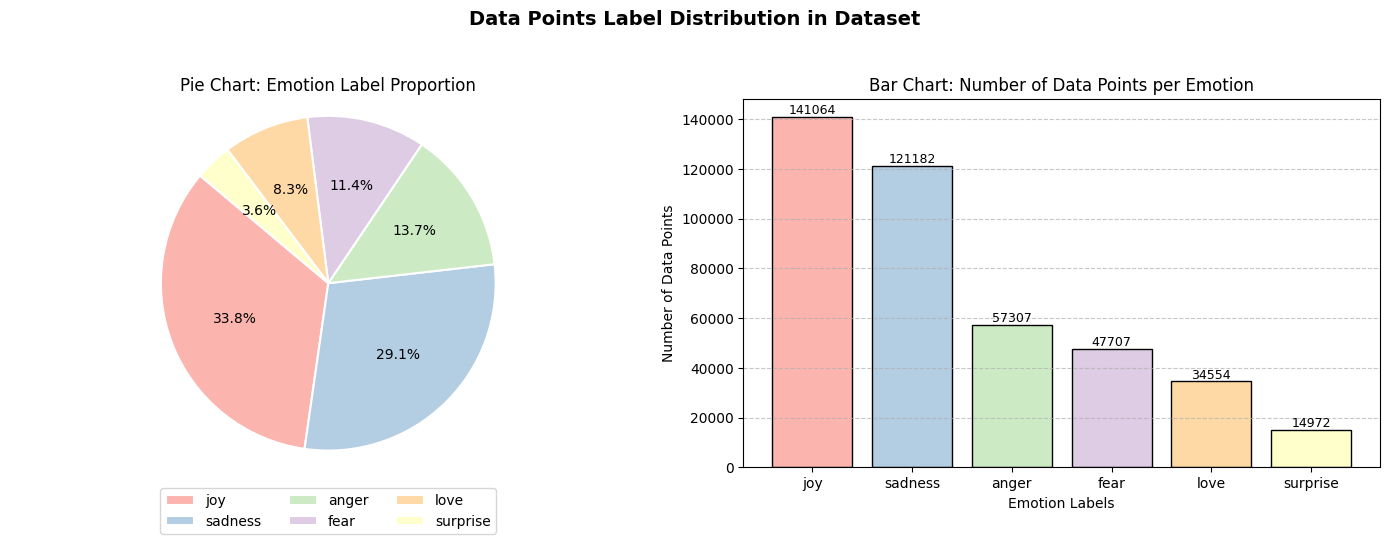

In [16]:

label_counts = df['label'].value_counts()
labels = label_counts.index.tolist()
sizes = label_counts.values.tolist()


colors = plt.cm.Pastel1.colors[:len(labels)]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# --- Pie Chart ---
patches, texts, autotexts = ax1.pie(
    sizes,
    labels=None,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5},
    textprops={'fontsize': 10}
)
ax1.axis('equal')
ax1.set_title('Pie Chart: Emotion Label Proportion', fontsize=12)
ax1.legend(patches, labels, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3)

# --- Bar Chart ---
bars = ax2.bar(labels, sizes, color=colors, edgecolor='black')
for bar in bars:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval + 1, str(yval), ha='center', va='bottom', fontsize=9)

ax2.set_title('Bar Chart: Number of Data Points per Emotion', fontsize=12) 
ax2.set_xlabel('Emotion Labels')
ax2.set_ylabel('Number of Data Points')
ax2.grid(axis='y', linestyle='--', alpha=0.7)


plt.suptitle("Data Points Label Distribution in Dataset", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  
plt.show()

In [17]:
# Balancing the dataset
num_instance = min(df['label'].value_counts())
df = df.groupby("label", group_keys=False).apply(lambda x: x.sample(n=num_instance, random_state=42)).reset_index(drop=True)

print(df["label"].value_counts())

label
anger       14972
fear        14972
joy         14972
love        14972
sadness     14972
surprise    14972
Name: count, dtype: int64


##Token Frequency in a sentence after preprocessing

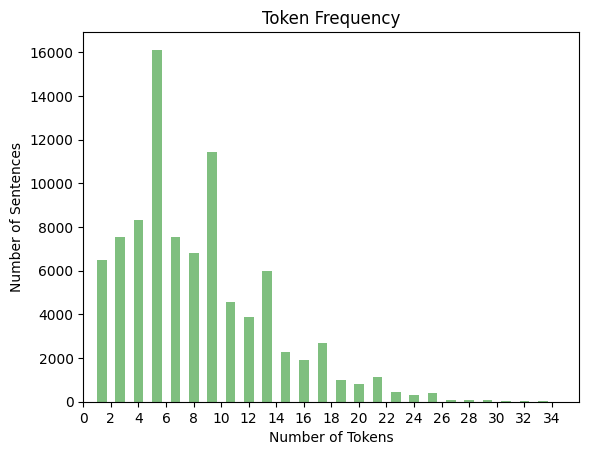

In [18]:
token_lengths = [len(t) for t in df['Text_lemmatized']]
plt.hist(token_lengths,bins=33,width = 0.7, fc="green",alpha=0.5)
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Sentences')
plt.title('Token Frequency')
x_Values = [i for i in range(36)]

plt.xticks(x_Values[::2])
plt.xlim(0,36)
plt.rcParams["figure.figsize"] = (10,8)
plt.show()

In [19]:
df['label'].value_counts()

label
anger       14972
fear        14972
joy         14972
love        14972
sadness     14972
surprise    14972
Name: count, dtype: int64

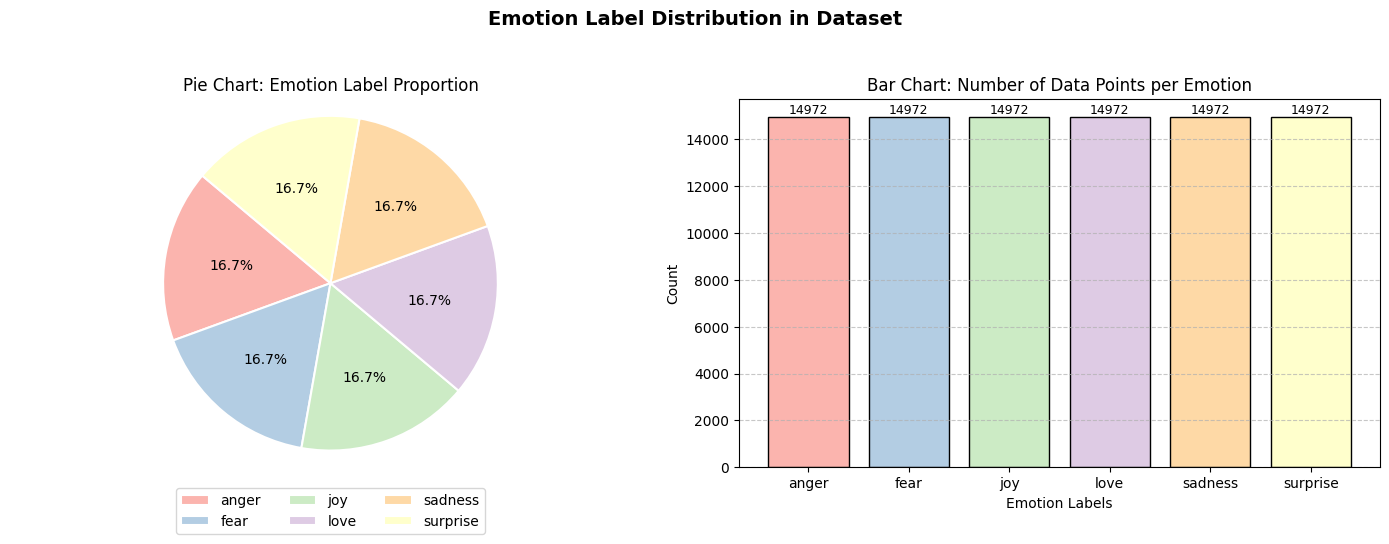

In [20]:
label_counts = df['label'].value_counts()
labels = label_counts.index.tolist()
sizes = label_counts.values.tolist()


palette = sns.color_palette("Set1", n_colors=len(labels))



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# --- Pie Chart ---
patches, texts, autotexts = ax1.pie(
    sizes,
    labels=None,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5},
    textprops={'fontsize': 10}
)
ax1.axis('equal')
ax1.set_title('Pie Chart: Emotion Label Proportion', fontsize=12)
ax1.legend(patches, labels, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3)

# --- Bar Chart ---
bars = ax2.bar(labels, sizes, color=colors, edgecolor='black')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height + 1, str(height),
             ha='center', va='bottom', fontsize=9)

ax2.set_title('Bar Chart: Number of Data Points per Emotion', fontsize=12)
ax2.set_xlabel('Emotion Labels')
ax2.set_ylabel('Count')
ax2.grid(axis='y', linestyle='--', alpha=0.7)


plt.suptitle("Emotion Label Distribution in Dataset", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


In [21]:
sentence_lengths = [len(sentence) for sentence in df['Text_lemmatized']]
label = df['label']

# In ra thống kê cơ bản
print("Độ dài tối thiểu:", min(sentence_lengths))
print("Độ dài tối đa:", max(sentence_lengths))
print("Độ dài trung bình:", sum(sentence_lengths) / len(sentence_lengths))


Độ dài tối thiểu: 1
Độ dài tối đa: 45
Độ dài trung bình: 8.40334179357022


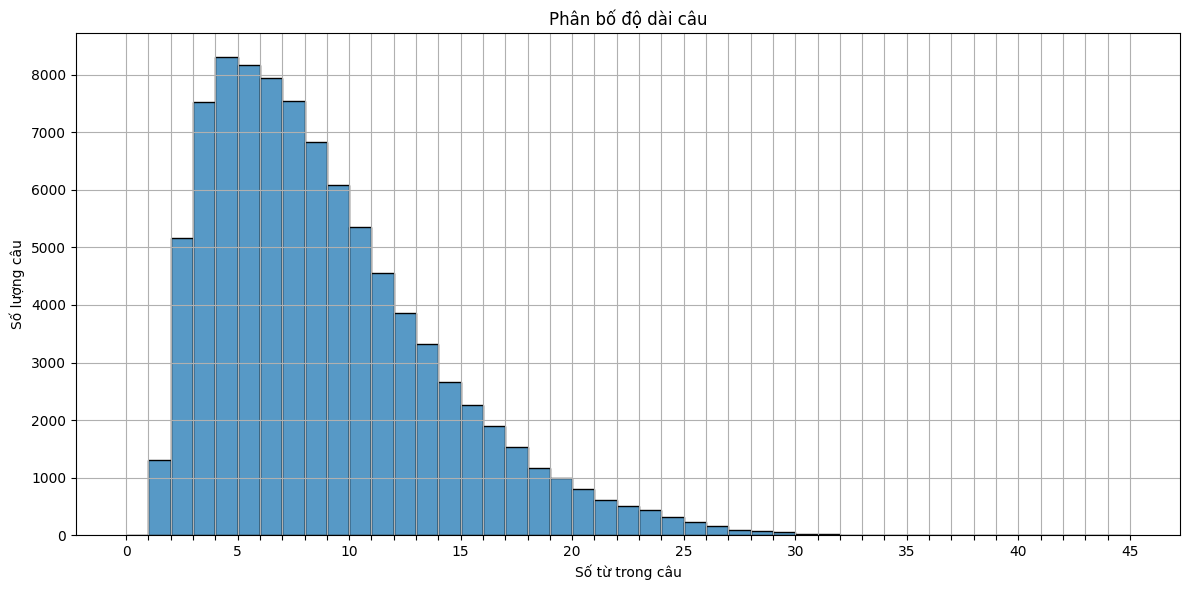

In [22]:
plt.figure(figsize=(12, 6))
sns.histplot(sentence_lengths, bins=range(0, max(sentence_lengths)+1), kde=False)

xticks = list(range(0, max(sentence_lengths)+1))
xtick_labels = [str(x) if x % 5 == 0 else ' ' for x in xticks]  # Giữ tick, ẩn label
plt.xticks(ticks=xticks, labels=xtick_labels)

plt.xlabel("Số từ trong câu")
plt.ylabel("Số lượng câu")
plt.title("Phân bố độ dài câu")
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
df['sentence_length'] = df['Text_lemmatized'].apply(len)


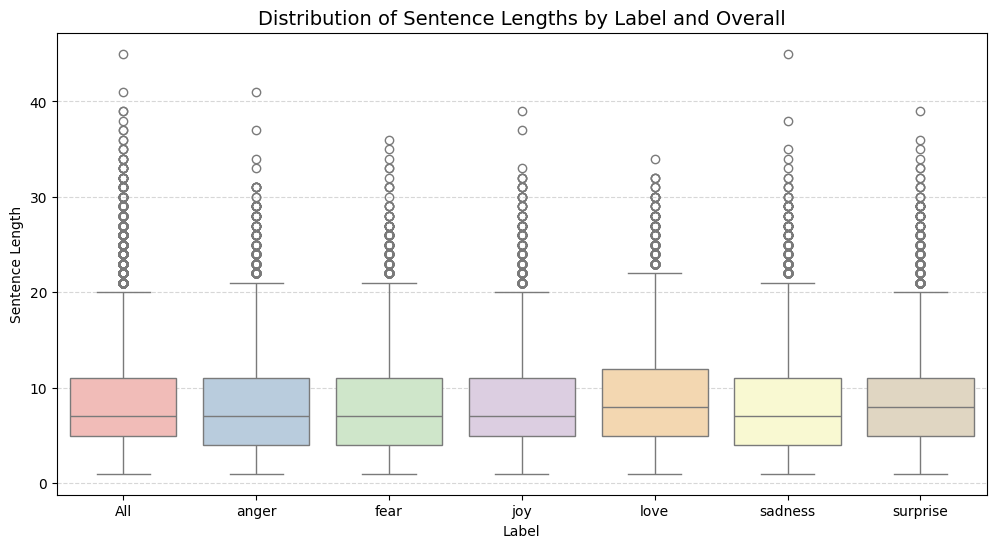

In [24]:

df['sentence_length'] = df['Text_lemmatized'].apply(len)


df_all = df.copy()
df_all['label'] = 'All'


df_combined = pd.concat([df_all, df], axis=0)


order = ['All'] + sorted(df['label'].unique().tolist())


plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='sentence_length', data=df_combined, order=order, palette='Pastel1')

plt.title('Distribution of Sentence Lengths by Label and Overall', fontsize=14)
plt.xlabel('Label')
plt.ylabel('Sentence Length')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()





In [25]:
# tổng số từ có trùng
# tổng từ không trùng

non_unique_words = 0
for i in range(df.shape[0]):
    non_unique_words += len(df['Text_lemmatized'].iloc[i])
    
unique_words = set()
for i in range(df.shape[0]):
    for j in range(len(df['Text_lemmatized'].iloc[i])):
        if df['Text_lemmatized'].iloc[i][j] not in unique_words:
            unique_words.add(df['Text_lemmatized'].iloc[i][j])

print(f"Number of non-unique words: {non_unique_words}")
print(f"Number of unique words: {len(unique_words)}")

Number of non-unique words: 754889
Number of unique words: 32425


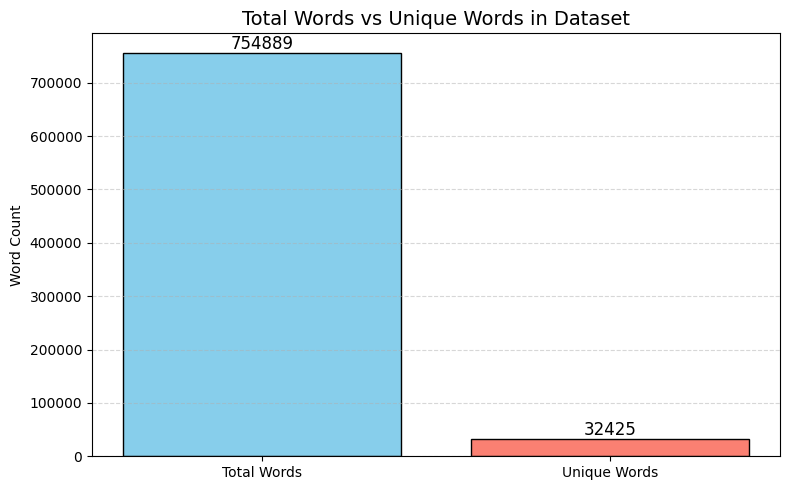

In [26]:

non_unique_words = 0
for i in range(df.shape[0]):
    non_unique_words += len(df['Text_lemmatized'].iloc[i])
    
unique_words = set()
for i in range(df.shape[0]):
    for word in df['Text_lemmatized'].iloc[i]:
        unique_words.add(word)

num_unique_words = len(unique_words)


labels_unq = ['Total Words', 'Unique Words']
counts = [non_unique_words, num_unique_words]
colors = ['skyblue', 'salmon']


plt.figure(figsize=(8, 5))
bars = plt.bar(labels_unq, counts, color=colors, edgecolor='black')

# Gắn số lên cột
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 100, str(height), 
             ha='center', va='bottom', fontsize=12)

plt.title('Total Words vs Unique Words in Dataset', fontsize=14)
plt.ylabel('Word Count')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [27]:
# số từ có trùng nhau mỗi class
class_non_unique_words = {f'{label}': 0 for label in df['label'].unique()}

for i in range(df.shape[0]):
    sentence = df['Text_tokenized'].iloc[i]
    label = df['label'].iloc[i]
    class_non_unique_words[label] += len(sentence)


for i in class_non_unique_words:
    print(f"{i} : {class_non_unique_words[i]}")


anger : 285662
fear : 284160
joy : 292556
love : 311517
sadness : 276469
surprise : 295604


In [28]:
# số từ không trùng nhau mỗi class
class_unique_words = {f'{label}': set() for label in df['label'].unique()}

for i in range(df.shape[0]):
    sentence = df['Text_lemmatized'].iloc[i]
    label = df['label'].iloc[i]
    for j in sentence:
        if j not in class_unique_words[label]:
            class_unique_words[label].add(j)


for i in class_unique_words:
    print(f"{i} : {len(class_unique_words[i])}")

anger : 12770
fear : 12118
joy : 13562
love : 13984
sadness : 12155
surprise : 12963


In [29]:
dict_words_class = {}

for word in unique_words:
    dict_words_class[word] = []
    for cls in class_unique_words:
        if word in class_unique_words[cls]:
            dict_words_class[word].append(cls)


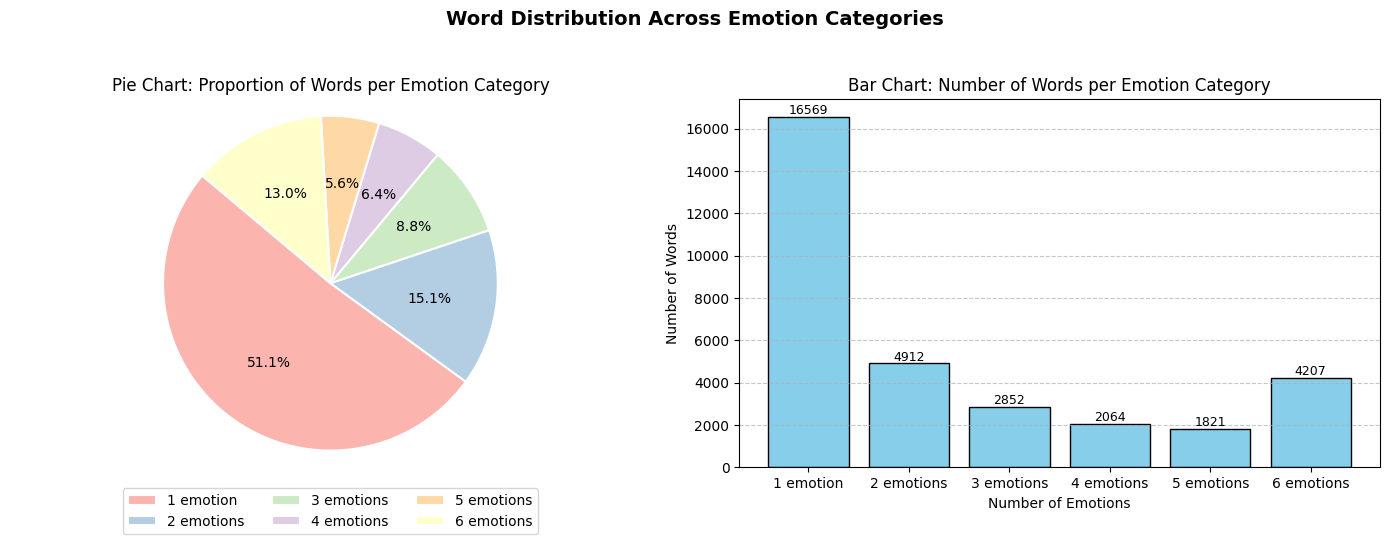

In [30]:
tempt = [0]*6
for word in dict_words_class:
    tempt[len(dict_words_class[word]) - 1]+=1


legend_labels = ['1 emotion', '2 emotions', '3 emotions', '4 emotions', '5 emotions', '6 emotions']
sizes = tempt

colors = plt.cm.Pastel1.colors


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# --- Pie chart ---
patches, texts, autotexts = ax1.pie(
    sizes,
    labels=None,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5},
    textprops={'fontsize': 10}
)
ax1.axis('equal')
ax1.set_title('Pie Chart: Proportion of Words per Emotion Category', fontsize=12)
ax1.legend(patches, legend_labels, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3)

# --- Bar chart ---
bars = ax2.bar(legend_labels, sizes, color='skyblue', edgecolor='black')
for bar in bars:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval + 1, str(yval), ha='center', va='bottom', fontsize=9)

ax2.set_title('Bar Chart: Number of Words per Emotion Category', fontsize=12)
ax2.set_xlabel('Number of Emotions')
ax2.set_ylabel('Number of Words')
ax2.grid(axis='y', linestyle='--', alpha=0.7)


plt.suptitle("Word Distribution Across Emotion Categories", fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


In [31]:
def freq(dictionary, word):
    if word in dictionary:
        dictionary[word] += 1
    else:
        dictionary[word] = 1

freq_word_class = {label:{} for label in labels}
freq_word_total = {}

for i in range(df.shape[0]):
    sentence = df['Text_lemmatized'].iloc[i]
    label = df['label'].iloc[i]
    for word in sentence:
        freq(freq_word_class[label], word)
        freq(freq_word_total, word)


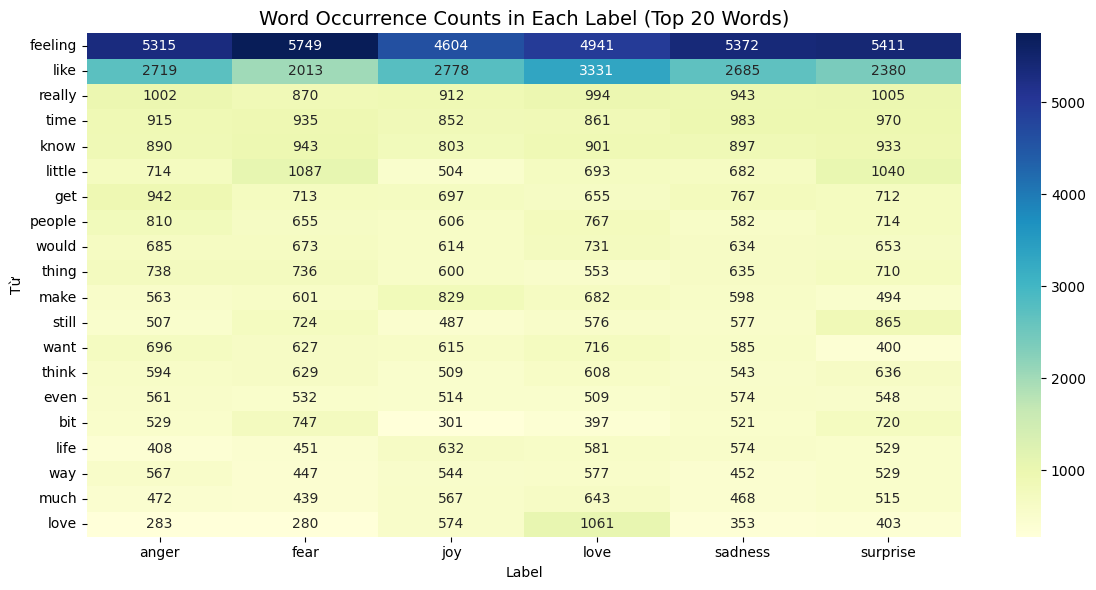

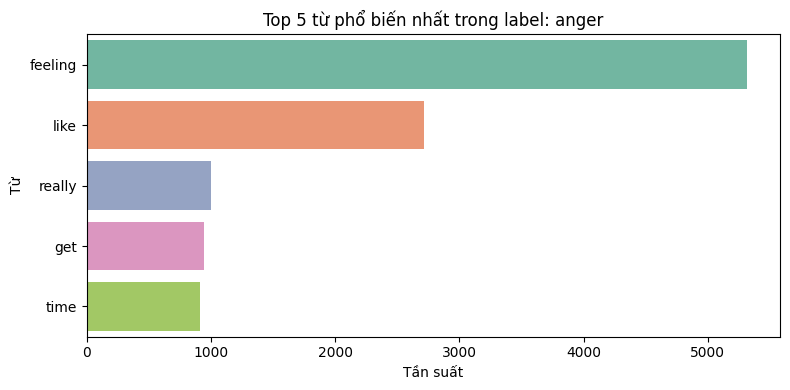

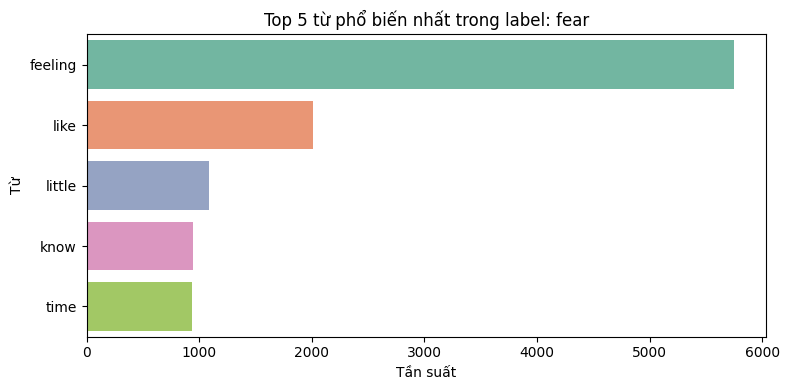

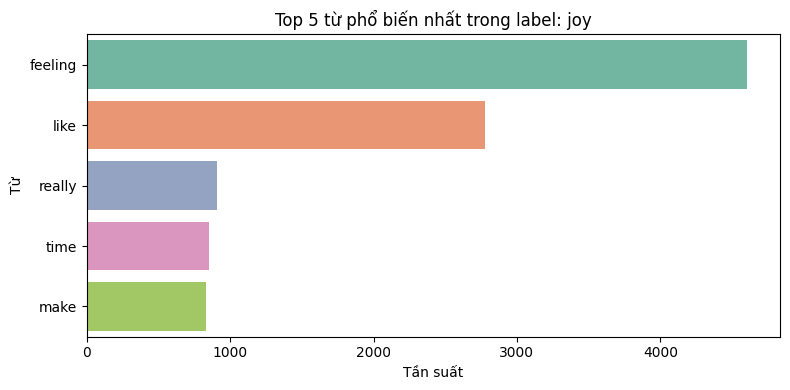

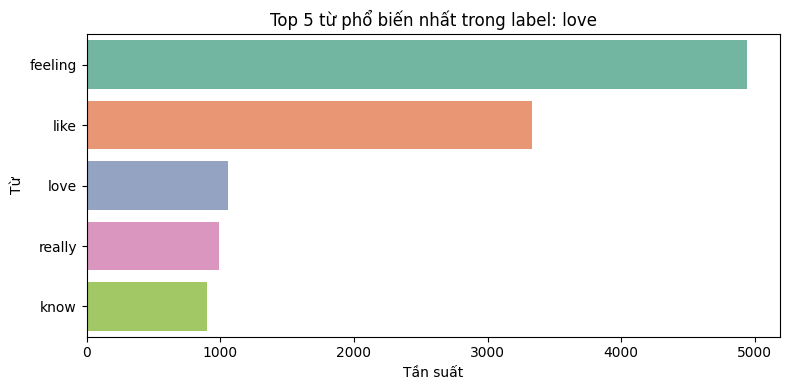

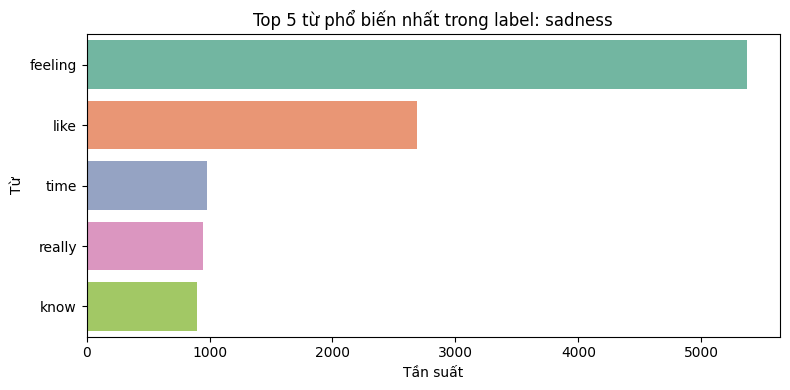

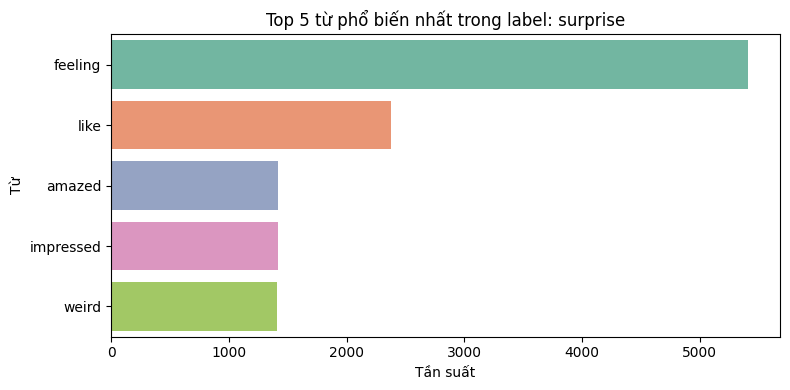

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


labels = list(freq_word_class.keys())


all_words = set()
for label in freq_word_class:
    all_words.update(freq_word_class[label].keys())


df_freq = pd.DataFrame(index=list(all_words), columns=labels).fillna(0)
for label in labels:
    for word, count in freq_word_class[label].items():
        df_freq.loc[word, label] = count


#top 20 từ xuất hiện nhiều nhất
top_words = df_freq.sum(axis=1).sort_values(ascending=False).head(20).index
df_top = df_freq.loc[top_words]

# Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df_top, annot=True, fmt="g", cmap='YlGnBu')
plt.title("Word Occurrence Counts in Each Label (Top 20 Words)", fontsize=14)
plt.xlabel("Label")
plt.ylabel("Từ")
plt.tight_layout()
plt.show()

# ===== Biểu đồ barplot: Top 5 từ phổ biến cho từng label =====
for label in labels:
    top_words_label = pd.Series(freq_word_class[label]).sort_values(ascending=False).head(5)
    plt.figure(figsize=(8, 4))
    sns.barplot(x=top_words_label.values, y=top_words_label.index, palette='Set2')
    plt.title(f"Top 5 từ phổ biến nhất trong label: {label}")
    plt.xlabel("Tần suất")
    plt.ylabel("Từ")
    plt.tight_layout()
    plt.show()


In [33]:
df['label'].unique()

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
      dtype=object)

##All in one (Text preprocessing)

In [34]:
def clean_text(text):
    text = remove_punct(text)
    text = tokenization(text)
    text = remove_stopwords(text)
    text = lemmatizer(text)
    return text



---

#3. Feature Extraction

---



In [35]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'],test_size=0.3, random_state = 0)

In [36]:
countVectorizer1 = CountVectorizer(analyzer=clean_text)
countVector1 = countVectorizer1.fit_transform(X_train)

countVector2 = countVectorizer1.transform(X_test)

tfidf_transformer_xtrain = TfidfTransformer()
x_train = tfidf_transformer_xtrain.fit_transform(countVector1)

tfidf_transformer_xtest = TfidfTransformer()
x_test = tfidf_transformer_xtest.fit_transform(countVector2)



---

#4. Models

---





1.   Support Vector Machine (SVM)
2.   Logistic Regression
3.   Random Forest Classifier



**Performance Matrix :**
1. **Accuracy** = $\frac{TP+TN}{TP+TN+FP+FN}$

2. **Precision** = $\frac{TP}{TP+FP}$

3. **Recall** = $\frac{TP}{TP+FN}$

4. **F1-score** = $\frac{2 \times Precision \times Recall}{Precision + Recall}$

##4.1 Support Vector Machine (SVM)

In [138]:
svm = SVC(kernel='linear',probability=True)

svm.fit(x_train, y_train)

y_pred = svm.predict(x_test)

svm_acc = accuracy_score(y_pred, y_test)
svm_prec = precision_score(y_test, y_pred, average='macro')
svm_recal = recall_score(y_test, y_pred, average='macro')
svm_cm = confusion_matrix(y_test,y_pred)
svm_f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy:', '{0:.3f}'.format(svm_acc*100))
print('Precision:', '{0:.3f}'.format(svm_prec*100))
print('Recall:', '{0:.3f}'.format(svm_recal*100))
print('F1-score:', '{0:.3f}'.format(svm_f1*100))
print(classification_report(y_test,y_pred))

Accuracy: 91.213
Precision: 91.373
Recall: 91.190
F1-score: 91.158
              precision    recall  f1-score   support

       anger       0.93      0.91      0.92      4466
        fear       0.89      0.86      0.88      4417
         joy       0.94      0.86      0.90      4460
        love       0.89      0.97      0.93      4548
     sadness       0.95      0.89      0.92      4574
    surprise       0.88      0.98      0.92      4485

    accuracy                           0.91     26950
   macro avg       0.91      0.91      0.91     26950
weighted avg       0.91      0.91      0.91     26950



###4.1.1 Confusion Matrix

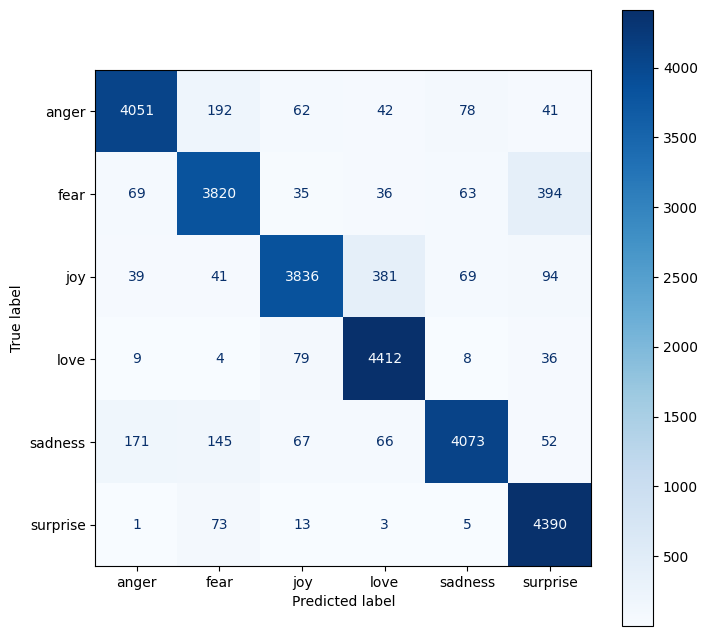

In [139]:
cm_display_svm = ConfusionMatrixDisplay(svm_cm, display_labels=svm.classes_)
fig, ax = plt.subplots(figsize=(8,8))
cm_display_svm.plot(ax=ax,cmap='Blues')

##4.2 Logistic Regression

In [140]:
logisticRegr = LogisticRegression()

logisticRegr.fit(x_train, y_train)

y_pred = logisticRegr.predict(x_test)

lr_acc = accuracy_score(y_pred, y_test)
lr_prec = precision_score(y_test, y_pred, average='macro')
lr_recal = recall_score(y_test, y_pred, average='macro')
lr_cm = confusion_matrix(y_test,y_pred)
lr_f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy:', '{0:.3f}'.format(lr_acc*100))
print('Precision:', '{0:.3f}'.format(lr_prec*100))
print('Recall:', '{0:.3f}'.format(lr_recal*100))
print('F1-score:', '{0:.3f}'.format(lr_f1*100))
print(classification_report(y_test,y_pred))

Accuracy: 90.642
Precision: 90.670
Recall: 90.618
F1-score: 90.595
              precision    recall  f1-score   support

       anger       0.93      0.91      0.92      4466
        fear       0.90      0.85      0.87      4417
         joy       0.90      0.88      0.89      4460
        love       0.90      0.94      0.92      4548
     sadness       0.93      0.90      0.91      4574
    surprise       0.89      0.96      0.92      4485

    accuracy                           0.91     26950
   macro avg       0.91      0.91      0.91     26950
weighted avg       0.91      0.91      0.91     26950



###4.2.1 Confusion Matrix

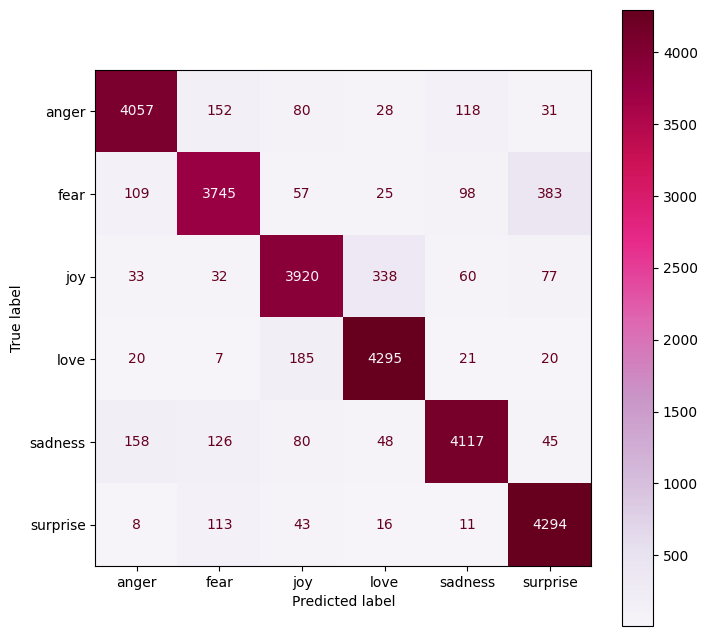

In [141]:
cm_display_lr = ConfusionMatrixDisplay(lr_cm, display_labels=logisticRegr.classes_)
fig, ax = plt.subplots(figsize=(8,8))
cm_display_lr.plot(ax=ax,cmap='PuRd')

##4.3 Random Forest Classifier

In [142]:
rfc = RandomForestClassifier(n_estimators=10, random_state=0)

rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_test)

rfc_acc = accuracy_score(y_pred, y_test)
rfc_prec = precision_score(y_test, y_pred, average='macro')
rfc_recal = recall_score(y_test, y_pred, average='macro')
rfc_cm = confusion_matrix(y_test,y_pred)
rfc_f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy:', '{0:.3f}'.format(rfc_acc*100))
print('Precision:', '{0:.3f}'.format(rfc_prec*100))
print('Recall:', '{0:.3f}'.format(rfc_recal*100))
print('F1-score:', '{0:.3f}'.format(rfc_f1*100))
print(classification_report(y_test,y_pred))

Accuracy: 88.857
Precision: 88.875
Recall: 88.836
F1-score: 88.815
              precision    recall  f1-score   support

       anger       0.91      0.91      0.91      4466
        fear       0.85      0.84      0.84      4417
         joy       0.89      0.86      0.87      4460
        love       0.89      0.95      0.92      4548
     sadness       0.93      0.87      0.90      4574
    surprise       0.88      0.91      0.89      4485

    accuracy                           0.89     26950
   macro avg       0.89      0.89      0.89     26950
weighted avg       0.89      0.89      0.89     26950



###4.3.1 Confusion Matrix

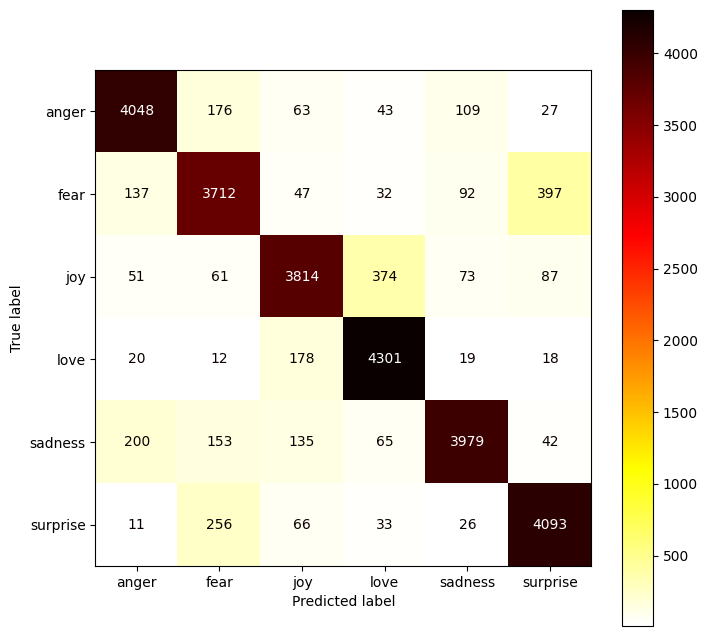

In [143]:
cm_display_rfc = ConfusionMatrixDisplay(rfc_cm, display_labels=rfc.classes_)
fig, ax = plt.subplots(figsize=(8,8))
cm_display_rfc.plot(ax=ax,cmap='hot_r')



---
#5. Summary Visualization
---



In [144]:
def get_prec_recall_per_emotion(cm):
    per_emotion_precision = []
    for i in range(len(cm)):
        count_per_emotion,accurate = 0,0
        for j in range(len(cm)):
            if i == j:
                accurate = cm[j][i]
            count_per_emotion += cm[j][i]
        per_emotion_precision.append(round((accurate/count_per_emotion)*100,3))

    per_emotion_recall = []
    for i in range(len(cm)):
        count_per_emotion,accurate = 0,0
        for j in range(len(cm)):
            if i == j:
                accurate = cm[i][j]
            count_per_emotion += cm[i][j]
        per_emotion_recall.append(round((accurate/count_per_emotion)*100,3))

    return per_emotion_precision, per_emotion_recall

##5.1. Precision of all models

In [145]:
svm_per_prec,svm_per_recall = get_prec_recall_per_emotion(svm_cm)
lr_per_prec,lr_per_recall = get_prec_recall_per_emotion(lr_cm)
rfc_per_prec,rfc_per_recall = get_prec_recall_per_emotion(rfc_cm)

per_precision_list = pd.DataFrame({'Support vector Machine' : svm_per_prec,
                                'Logistic Regression' : lr_per_prec,
                                'Random Forest' : rfc_per_prec},
                                index=svm.classes_)
per_precision_list

,Support vector Machine,Logistic Regression,Random Forest
anger,93.341,92.520,90.620
fear,89.357,89.701,84.943
joy,93.744,89.805,88.636
love,89.312,90.421,88.717
sadness,94.809,93.040,92.578
surprise,87.677,88.536,87.757


##5.2. Recall of all models

In [146]:
per_recall_list = pd.DataFrame({'Support vector Machine' : svm_per_recall,
                                'Logistic Regression' : lr_per_recall,
                                'Random Forest' : rfc_per_recall},
                                index=svm.classes_)
per_recall_list

,Support vector Machine,Logistic Regression,Random Forest
anger,90.708,90.842,90.640
fear,86.484,84.786,84.039
joy,86.009,87.892,85.516
love,97.010,94.437,94.569
sadness,89.047,90.009,86.992
surprise,97.882,95.741,91.260


##5.3 Accuracy Visualization for all models

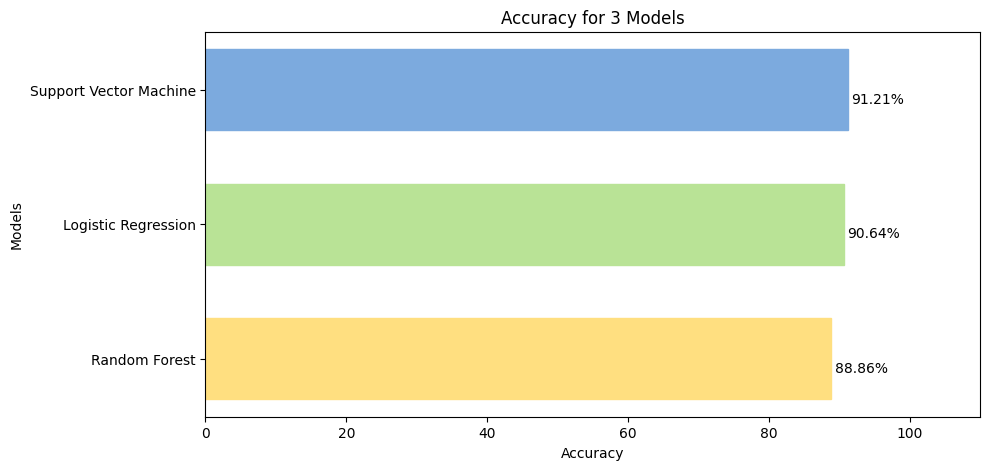

In [147]:
algorithms = ['Random Forest','Logistic Regression','Support Vector Machine']
algorithm_acc = [rfc_acc*100, lr_acc*100, svm_acc*100]

# Figure Size
fig = plt.figure(figsize =(10, 5))
bar_list = plt.barh(algorithms, algorithm_acc,height = 0.6,color='black')
bar_list[0].set_color('#FFDF80')
bar_list[1].set_color('#B9E396')
bar_list[2].set_color('#7CAADE')
plt.xlabel('Accuracy',color='black')
plt.ylabel('Models',color='black')
plt.title('Accuracy for 3 Models')
plt.xlim(0,110)

for i, v in enumerate(algorithm_acc):
    plt.text(v + 0.5, i - 0.1, str(round(v,2))+'%', color='black',fontsize=10)

plt.show()

In [ ]:
# import joblib

# model_performance = {
#     'SVM': svm_acc,
#     'Logistic Regression': lr_acc,
#     'Random Forest': rfc_acc
# }

# model_objects = {
#     'SVM': svm,
#     'Logistic Regression': logisticRegr,
#     'Random Forest': rfc
# }

# best_model_name = max(model_performance, key=lambda k: model_performance[k])
# best_model = model_objects[best_model_name]

# joblib.dump(countVectorizer1, 'count_vectorizer.pkl')
# joblib.dump(tfidf_transformer_xtrain, 'tfidf_transformer.pkl')
# joblib.dump(best_model, 'best_emotion_model.pkl')

# print(f'Đã lưu thành công model {best_model_name} (Accuracy: {model_performance[best_model_name]*100:.2f}%)')

Đã lưu thành công model SVM (Accuracy: 91.21%)


In [151]:
import os
import joblib

model_file = 'models'
os.makedirs(model_file, exist_ok=True)


model_performance = {
    'SVM': svm_acc,
    'Logistic Regression': lr_acc,
    'Random Forest': rfc_acc
}

model_objects = {
    'SVM': svm,
    'Logistic Regression': logisticRegr,
    'Random Forest': rfc
}


best_model_name = max(model_performance, key=lambda k: model_performance[k])
best_model = model_objects[best_model_name]


joblib.dump(countVectorizer1, f'{model_file}/count_vectorizer.pkl')
joblib.dump(tfidf_transformer_xtrain, f'{model_file}/tfidf_transformer.pkl')


# for name, model in model_objects.items():
#     joblib.dump(model, f'{model_file}/{name.lower().replace(" ", "_")}_model.pkl')


joblib.dump(best_model, f'{model_file}/best_emotion_model.pkl')


print(f'Đã lưu thành công model {best_model_name} (Accuracy: {model_performance[best_model_name]*100:.2f}%) vào thư mục /{model_file}/')


Đã lưu thành công model SVM (Accuracy: 91.21%) vào thư mục /models/


In [149]:
#Demo
sample_texts = [
    "I'm feeling absolutely thrilled about the upcoming trip!",
    "The service was terrible and I'm extremely disappointed.",
    "This situation makes me anxious and worried."
]

loaded_count_vect = joblib.load('count_vectorizer.pkl')
loaded_tfidf_trans = joblib.load('tfidf_transformer.pkl')
loaded_model = joblib.load('best_emotion_model.pkl')

sample_counts = loaded_count_vect.transform(sample_texts)

sample_tfidf = loaded_tfidf_trans.transform(sample_counts)

predictions = loaded_model.predict(sample_tfidf)
probabilities = loaded_model.predict_proba(sample_tfidf)

for text, pred, prob in zip(sample_texts, predictions, probabilities):
    print(f"\nText: {text}")
    print(f"Predicted Emotion: {pred}")
    print("Probabilities:")
    for cls, p in zip(loaded_model.classes_, prob):
        print(f"  {cls}: {p:.4f}")


Text: I'm feeling absolutely thrilled about the upcoming trip!
Predicted Emotion: joy
Probabilities:
  anger: 0.0001
  fear: 0.0001
  joy: 0.9959
  love: 0.0027
  sadness: 0.0004
  surprise: 0.0008

Text: The service was terrible and I'm extremely disappointed.
Predicted Emotion: sadness
Probabilities:
  anger: 0.0000
  fear: 0.0000
  joy: 0.0000
  love: 0.0000
  sadness: 1.0000
  surprise: 0.0000

Text: This situation makes me anxious and worried.
Predicted Emotion: fear
Probabilities:
  anger: 0.0006
  fear: 0.9982
  joy: 0.0002
  love: 0.0000
  sadness: 0.0001
  surprise: 0.0009
